
This study employs a hybrid econometric and machine learning method to model volatility and detect regimes in the SPDR S&P 500 ETF Trust (SPY) using historical data from 2010 to 2024. The approach integrates multiple GARCH-family models and Hidden Markov Models (HMMs) and scales the produced features for use in deep learning-based prediction.


Data acquisition and preprocessing
The data includes open, high, low, close, and volume data. Log returns were calculated as the first difference of the logarithmic closing prices, which were then scaled for volatility modeling.

Volatility Modeling using GARCH Family Models
Volatility was estimated with five GARCH-family models implemented via the arch package:

Volatility Modeling using GARCH Family Models
Five GARCH-family models were utilized to model volatility using the arch library:

GARCH(1,1): Symmetric model with constant reaction to shocks.

EGARCH(1,1): Reflects asymmetric impacts on volatility using a logarithmic specification.

GJR-GARCH(1,1): Handles leverage effects using an additional asymmetric term.

APARCH(1,1): Generalized form which allows power transformation of conditional standard deviation.

IGARCH(1,1): Models long-run volatility using unit root behavior.

The models were fitted to the scaled returns, and conditional volatility series were obtained. A volatility-adjusted return was computed by raw returns divided by their respective conditional volatility, where the focus was on GARCH (1,1)




Interpretation:

Regime 0: This appears to capture episodes of large market movement (up or down), probably with high volatility or financial stress (e.g., the COVID-19 market crash in early 2020).

Regime 1: This regime seems to incorporate phases of more frequent but moderate fluctuations. It could represent medium volatility situations, uncertain or transitional market phases.

Regime 2: These readings are closely bunched around zero returns, suggesting low-volatility or stable market conditions.



Description:
The line graph compares raw daily returns on SPY with GARCH-adjusted returns . The adjustment is done using a GARCH (1,1) model to account for time-varying volatility.

Interpretation:

The black line is showing real percentage returns, which are observed to be clustered and have a large range of amplitude.
The grey line is the returns divided by the conditional volatility from the GARCH model. These are more spread out vertically, which is normalization by risk.
Insights:

GARCH-adjusted returns highlight times of volatility clustering, when extreme moves tend to follow each other.
Normalizing returns by volatility enables us to improve model performance on tasks like classification or prediction by reducing noise from time-varying variance.


In [39]:
import random
import numpy as np
import tensorflow as tf

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


[*********************100%***********************]  1 of 1 completed


<ipython-input-40-49373578b2b3>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['3STATE - RegimeS'] = hidden_states
<ipython-input-40-49373578b2b3>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Garch_3_STATE-RegimeS'] = hidden_states_Garch
<ipython-input-40-49373578b2b3>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

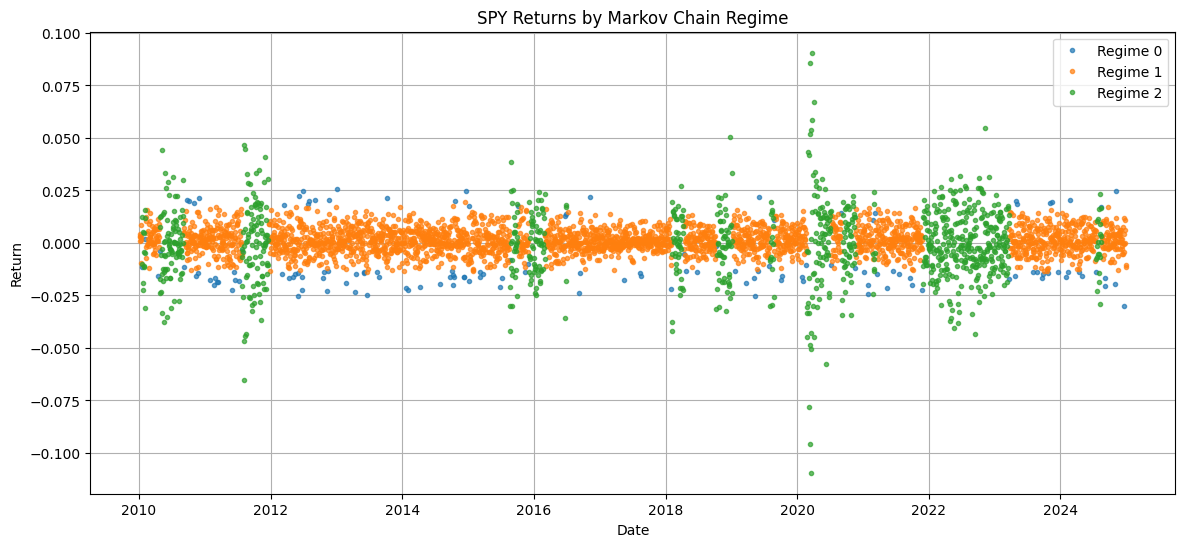

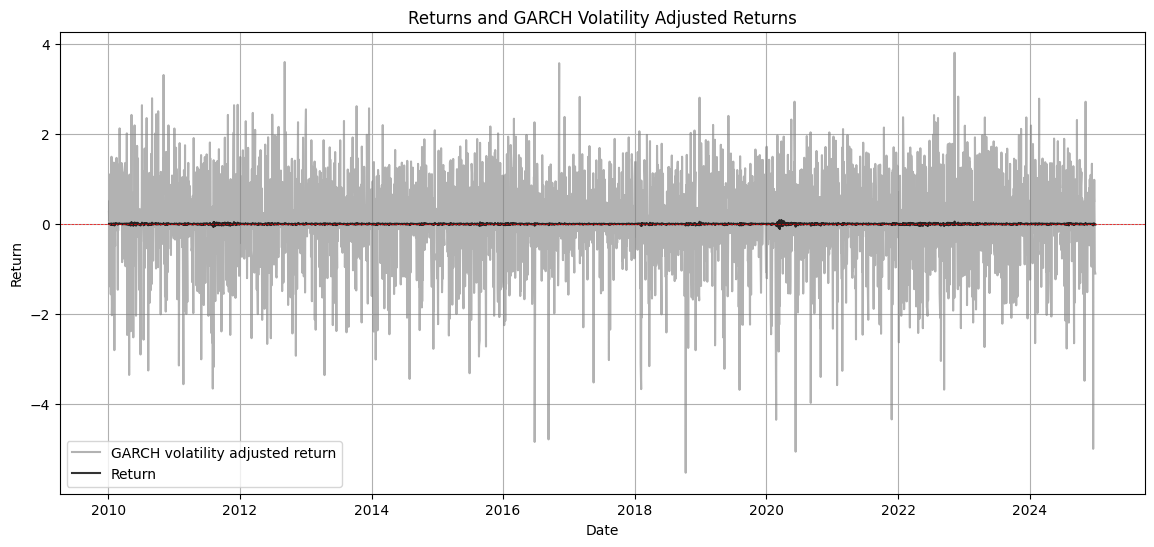

Price,Close,High,Low,Open,Volume,Return,GARCH_Adjusted_Return,GARCH_vol,EGARCH_vol,GJR_vol,APARCH_vol,IGARCH_vol,3STATE - RegimeS,Garch_3_STATE-RegimeS,Target
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2010-01-05,85.995461,86.033303,85.405156,85.715447,111579900,0.002647,0.273714,0.009670,0.009665,0.009653,0.010116,0.009670,1,2,0
2010-01-06,86.056015,86.267919,85.844111,85.912221,116074400,0.000704,0.079227,0.008888,0.008754,0.008951,0.009029,0.008888,1,2,1
2010-01-07,86.419250,86.525202,85.654879,85.897055,131091100,0.004221,0.516144,0.008178,0.007792,0.008325,0.008030,0.008178,1,2,1
2010-01-08,86.706863,86.744706,86.018176,86.192237,126402800,0.003328,0.433122,0.007684,0.007425,0.007796,0.007334,0.007684,1,2,1
2010-01-11,86.827950,87.130666,86.457112,87.092829,106375700,0.001396,0.193817,0.007205,0.006978,0.007325,0.006718,0.007205,1,0,-1


In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'arch' is installed and import 'arch_model'
try:
    from arch import arch_model
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "arch"])
    from arch import arch_model

# Check and install 'arch' package if not installed
try:
    import arch
except ImportError:
    !pip install arch
    import arch  # Try importing again after installation
    from arch import arch_model
# Step 1: Download Data
data = yf.download("SPY", start="2010-01-01", end="2024-12-31")
data['Return'] = data['Close'].pct_change().dropna()
data = data.dropna()

# Step 2: Fit a Symmetric GARCH(1,1) Model
returns = data['Return'] * 100  # Scale returns for GARCH fitting
garch_model = arch_model(returns, vol='Garch', p=1, q=1)  # Symmetric GARCH (no 'o' term)
garch_fit = garch_model.fit(disp='off')

# Step 3: Extract Conditional Volatility
cond_vol = garch_fit.conditional_volatility / 100  # Bring back to original scale

# Step 4: Calculate Volatility-Adjusted Returns
data['GARCH_Adjusted_Return'] = data['Return'] / cond_vol
#data['Cond_Volatility'] = cond_vol.values # GARCH VOL


# GARCH(1,1) Model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
data['GARCH_vol'] = np.nan
data.loc[returns.index, 'GARCH_vol'] = garch_fit.conditional_volatility / 100

# EGARCH(1,1) Model
egarch_model = arch_model(returns, vol='EGARCH', p=1, q=1)
egarch_fit = egarch_model.fit(disp='off')
data['EGARCH_vol'] = np.nan
data.loc[returns.index, 'EGARCH_vol'] = egarch_fit.conditional_volatility / 100


# GJR-GARCH(1,1) Model
gjr_model = arch_model(returns, vol='Garch', p=1, o=1, q=1)
gjr_fit = gjr_model.fit(disp='off')
data['GJR_vol'] = np.nan
data.loc[returns.index, 'GJR_vol'] = gjr_fit.conditional_volatility / 100

# APARCH(1,1) Model
aparch_model = arch_model(returns, vol='APARCH', p=1, o=1, q=1)
aparch_fit = aparch_model.fit(disp='off')
data['APARCH_vol'] = np.nan
data.loc[returns.index, 'APARCH_vol'] = aparch_fit.conditional_volatility / 100

# IGARCH(1,1) Model (approximation)
igarch_model = arch_model(returns, vol='Garch', p=1, q=1)
igarch_fit = igarch_model.fit(disp='off')
data['IGARCH_vol'] = np.nan
data.loc[returns.index, 'IGARCH_vol'] = igarch_fit.conditional_volatility / 100

# Step 6: Markov Chain (Hidden Markov Model) for Regime Detection
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

# Prepare the input: volatility adjusted returns reshaped for HMM
X = data['Return'].dropna().values.reshape(-1, 1)

# Create and fit a 2-state HMM
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
hmm_model.fit(X)

# Predict hidden states (regimes)
hidden_states = hmm_model.predict(X)

# Add states to DataFrame
data = data.iloc[-len(hidden_states):]  # Align the index (in case of any mismatch)
data['3STATE - RegimeS'] = hidden_states


### Volatility regiems -------------------------- added
# Prepare the input: volatility adjusted returns reshaped for HMM
G = data['GARCH_Adjusted_Return'].dropna().values.reshape(-1, 1)

# Create and fit a 2-state HMM
hmm_model_garch = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
hmm_model_garch.fit(G)

# Predict hidden states (regimes)
hidden_states_Garch = hmm_model_garch.predict(G)

# Add states to DataFrame
data = data.iloc[-len(hidden_states_Garch):]  # Align the index (in case of any mismatch)
data['Garch_3_STATE-RegimeS'] = hidden_states_Garch

# adding target label for deep learning model training
#data['Target'] = data['Return'].shift(-1)
# Create Binary Target
daily_r = 0.00077  # your threshold

data['Target'] = data['Return'].shift(-1).apply(
    lambda x: 1 if x > daily_r else (0 if x >= 0 else -1)
)

# Optional: Plot returns colored by regime
plt.figure(figsize=(14,6))
for i in range(hmm_model.n_components):
    mask = (data['3STATE - RegimeS'] == i)
    plt.plot(data.index[mask], data['Return'][mask], '.', label=f'Regime {i}', alpha=0.7)

plt.title('SPY Returns by Markov Chain Regime')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Plot the Regular and Volatility-Adjusted Returns
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['GARCH_Adjusted_Return'], color='grey', label='GARCH volatility adjusted return', alpha=0.6)
plt.plot(data.index, data['Return'], color='black', label='Return', alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
plt.title('Returns and GARCH Volatility Adjusted Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

data.head()

In [41]:
# Count how many 0s and 1s
target_counts = data['Target'].value_counts()

# Calculate percentages
target_percentages = data['Target'].value_counts(normalize=True) * 100

# Combine both
summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percentages.round(2)
})

print(summary)


        Count  Percentage
Target                   
 1       1862       49.36
-1       1675       44.41
 0        235        6.23


In [42]:
data.describe()

Price,Close,High,Low,Open,Volume,Return,GARCH_Adjusted_Return,GARCH_vol,EGARCH_vol,GJR_vol,APARCH_vol,IGARCH_vol,3STATE - RegimeS,Garch_3_STATE-RegimeS,Target
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,,,
count,3772.000000,3772.000000,3772.000000,3772.000000,3.772000e+03,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,247.905728,249.193381,246.418892,247.865016,1.118177e+08,0.000568,0.060332,0.009478,0.009422,0.009454,0.009320,0.009478,1.208112,1.654560,0.049576
std,132.554664,133.230166,131.783158,132.543476,6.909947e+07,0.010742,0.997620,0.005075,0.004391,0.005502,0.005052,0.005075,0.490058,0.625815,0.967207
min,78.033234,78.964747,77.216258,78.728053,2.027000e+07,-0.109424,-5.525096,0.004486,0.003000,0.004626,0.003573,0.004486,0.000000,0.000000,-1.000000
25%,138.801788,139.167857,138.272182,138.619002,6.616045e+07,-0.003709,-0.447545,0.006440,0.006558,0.006122,0.006099,0.006440,1.000000,1.000000,-1.000000
50%,214.013084,214.662685,213.256929,214.083357,9.190805e+07,0.000686,0.087837,0.008034,0.008333,0.007737,0.007923,0.008034,1.000000,2.000000,0.000000
75%,363.304192,365.993162,359.373755,362.615273,1.360314e+08,0.005790,0.684672,0.011004,0.011231,0.010978,0.011103,0.011004,1.000000,2.000000,1.000000
max,603.954346,605.206363,603.169379,603.835154,7.178287e+08,0.090603,3.806923,0.070477,0.058905,0.079146,0.070073,0.070477,2.000000,2.000000,1.000000


Market Regime Detection with Hidden Markov Models (HMM)
To model regime-switching behavior for returns, a three-state Gaussian HMM from the hmmlearn package was fitted to:

Raw returns.

GARCH volatility-adjusted returns.

Each model supplied discrete regime labels for each observation, corresponding to alternative market states (e.g., high-volatility bearish, low-volatility bullish).

Target Variable for Supervised Learning
A binary classification target was generated by forward-shifting daily returns:

Label 1 if the next day's return was higher than +0.5%, else 0.

This binary setup enables prediction activities by classification suitable for deep learning models.

In [43]:
#-------------------------------
#              RSI
#-------------------------------
def compute_rsi_signal_only(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    signals = [0]  # First signal is hold

    for i in range(1, len(rsi)):
        try:
            prev_rsi = rsi.iloc[i - 1].item()
            curr_rsi = rsi.iloc[i].item()
        except:
            signals.append(0)
            continue

        if pd.isna(prev_rsi) or pd.isna(curr_rsi):
            signals.append(0)
        elif curr_rsi > 30 and prev_rsi <= 30:
            signals.append(1)   # Buy
        elif curr_rsi < 70 and prev_rsi >= 70:
            signals.append(-1)  # Sell
        else:
            signals.append(0)   # Hold

    return pd.Series(signals, index=prices.index)
data['RSI_Signal'] = compute_rsi_signal_only(data['Close'])


In [44]:
# --- MACD Indicator Feature with Discrete Signal Output ---
#-------------------------------
#              MACD
#-------------------------------
# Calculate MACD and Signal Line
def compute_macd(close_prices, short=12, long=26, signal=9):
    ema_short = close_prices.ewm(span=short, adjust=False).mean()
    ema_long = close_prices.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, macd_signal

# Use the 'Return' as a proxy for price signal (or replace with 'Close' if available)
macd_line, macd_signal = compute_macd(data['Return'])

# Add MACD values to DataFrame
data['MACD_Line'] = macd_line
data['MACD_Signal'] = macd_signal

# Generate discrete trading signals
def macd_to_signal(macd, signal):
    if macd > signal:
        return 1   # Buy
    elif macd < signal:
        return -1  # Sell
    else:
        return 0   # Hold

data['MACD_Signal_Label'] = [macd_to_signal(m, s) for m, s in zip(macd_line, macd_signal)]

# OPTIONAL: Preview output

data.drop(columns=['MACD_Line','MACD_Signal'])

Price,Close,High,Low,Open,Volume,Return,GARCH_Adjusted_Return,GARCH_vol,EGARCH_vol,GJR_vol,APARCH_vol,IGARCH_vol,3STATE - RegimeS,Garch_3_STATE-RegimeS,Target,RSI_Signal,MACD_Signal_Label
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2010-01-05,85.995461,86.033303,85.405156,85.715447,111579900,0.002647,0.273714,0.009670,0.009665,0.009653,0.010116,0.009670,1,2,0,0,0
2010-01-06,86.056015,86.267919,85.844111,85.912221,116074400,0.000704,0.079227,0.008888,0.008754,0.008951,0.009029,0.008888,1,2,1,0,-1
2010-01-07,86.419250,86.525202,85.654879,85.897055,131091100,0.004221,0.516144,0.008178,0.007792,0.008325,0.008030,0.008178,1,2,1,0,1
2010-01-08,86.706863,86.744706,86.018176,86.192237,126402800,0.003328,0.433122,0.007684,0.007425,0.007796,0.007334,0.007684,1,2,1,0,1
2010-01-11,86.827950,87.130666,86.457112,87.092829,106375700,0.001396,0.193817,0.007205,0.006978,0.007325,0.006718,0.007205,1,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,592.906433,593.514589,585.897488,589.117842,57635800,0.005988,0.489220,0.012240,0.011441,0.014055,0.010398,0.012240,1,2,1,0,1
2024-12-24,599.496582,599.536501,593.684050,594.272307,33160100,0.011115,0.982933,0.011308,0.010728,0.012895,0.009381,0.011308,1,2,0,0,1


### 4.3 Deep Learning Model Evaluation and Results
After feature engineering using GARCH volatility, regime states (via HMM), and technical indicators (RSI, MACD), the feedforward deep neural network (DNN) was trained to predict the direction of future returns for SPY ETF.  

Model Structure
 Dense layer of 512 neurons  and LeakyReLU activation
Dense layer with 512 neurons and LeakyReLU activation

Dropout (0.5)

Dense layer with 256 neurons and LeakyReLU activation

Dropout (0.5)

Dense layer with 128 neurons and LeakyReLU

Output layer with sigmoid activation for binary classification

Compiled model with Adam optimizer and binary crossentropy loss function and trained on 20 epochs, batch size 64, and validation split of 10\%.
Training accuracy increased consistently and validation accuracy fluctuated slightly before stabilizing near 71.8%, indicating fair generalization.
Final Evaluation on Test Set
Test Accuracy: 68.5%

Test Loss: 0.6065




In [45]:
data

Price,Close,High,Low,Open,Volume,Return,GARCH_Adjusted_Return,GARCH_vol,EGARCH_vol,GJR_vol,APARCH_vol,IGARCH_vol,3STATE - RegimeS,Garch_3_STATE-RegimeS,Target,RSI_Signal,MACD_Line,MACD_Signal,MACD_Signal_Label
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,
2010-01-05,85.995461,86.033303,85.405156,85.715447,111579900,0.002647,0.273714,0.009670,0.009665,0.009653,0.010116,0.009670,1,2,0,0,0.000000,0.000000,0
2010-01-06,86.056015,86.267919,85.844111,85.912221,116074400,0.000704,0.079227,0.008888,0.008754,0.008951,0.009029,0.008888,1,2,1,0,-0.000155,-0.000031,-1
2010-01-07,86.419250,86.525202,85.654879,85.897055,131091100,0.004221,0.516144,0.008178,0.007792,0.008325,0.008030,0.008178,1,2,1,0,0.000006,-0.000024,1
2010-01-08,86.706863,86.744706,86.018176,86.192237,126402800,0.003328,0.433122,0.007684,0.007425,0.007796,0.007334,0.007684,1,2,1,0,0.000061,-0.000007,1
2010-01-11,86.827950,87.130666,86.457112,87.092829,106375700,0.001396,0.193817,0.007205,0.006978,0.007325,0.006718,0.007205,1,0,-1,0,-0.000051,-0.000016,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,592.906433,593.514589,585.897488,589.117842,57635800,0.005988,0.489220,0.012240,0.011441,0.014055,0.010398,0.012240,1,2,1,0,-0.000274,-0.000924,1
2024-12-24,599.496582,599.536501,593.684050,594.272307,33160100,0.011115,0.982933,0.011308,0.010728,0.012895,0.009381,0.011308,1,2,0,0,0.000654,-0.000609,1


In [73]:
data.groupby('Target').count()['Return']


,Return
Target,
0,1791
1,141
2,1840


In [74]:
Counter(data['Target'])

Counter({0: 1791, 2: 1840, 1: 141})

########################################

Target Distribution: Counter({2: 1981, 1: 1791})
Class Weights: {0: np.float64(1.0540845070422535), 1: np.float64(0.951194712760549)}
Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4870 - loss: 0.9438 - val_accuracy: 0.5567 - val_loss: 0.7020 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5088 - loss: 0.6992 - val_accuracy: 0.5400 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5190 - loss: 0.6819 - val_accuracy: 0.5600 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5453 - loss: 0.6774 - val_accuracy: 0.5533 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/40
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5614 - loss: 0.6718
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5614 - loss: 0.6718 - val_accuracy: 0.5100 - va

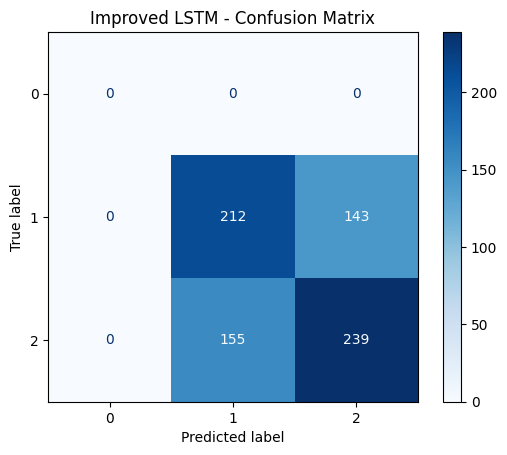


Classification Report:
              precision    recall  f1-score   support

           1     0.5777    0.5972    0.5873       355
           2     0.6257    0.6066    0.6160       394

    accuracy                         0.6021       749
   macro avg     0.6017    0.6019    0.6016       749
weighted avg     0.6029    0.6021    0.6024       749



In [75]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# === CLEAN & PREPARE DATA ===
data = data.dropna()

data['Target'] = np.where(data['Target'] == -1, 0,
                  np.where(data['Target'] == 0, 1, 2))  # 0=down, 1=neutral, 2=up

print("Target Distribution:", Counter(data['Target']))

X = data.drop(columns=['Close', 'High', 'Low', 'Open', 'Target']).values
y = data['Target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

seq_len = 30

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len)
y_seq_cat = to_categorical(y_seq, num_classes=3)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_seq, y_seq):
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq_cat[train_idx], y_seq_cat[test_idx]
    y_test_labels = y_seq[test_idx]

# === COMPUTE CLASS WEIGHTS ===
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_seq),
                                     y=y_seq)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# === MODEL ===
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# === CALLBACKS ===
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weight_dict,
    verbose=1
)

# === EVALUATE ===
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")

# === PREDICT ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_labels, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Improved LSTM - Confusion Matrix")
plt.grid(False)
plt.show()

# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, digits=4))


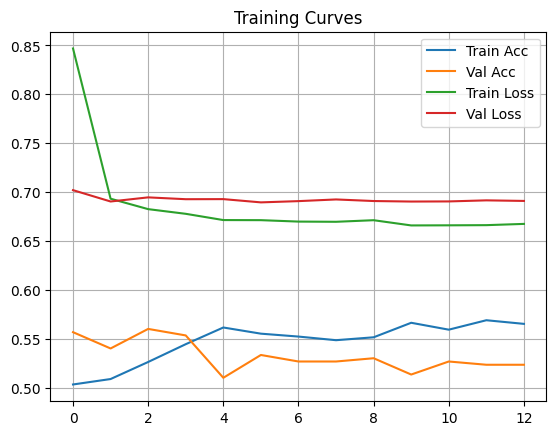

In [76]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training Curves')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4774 - loss: 0.9632 - val_accuracy: 0.6316 - val_loss: 0.6978
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6082 - loss: 0.7236 - val_accuracy: 0.5789 - val_loss: 0.6607
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6356 - loss: 0.6512 - val_accuracy: 0.5921 - val_loss: 0.6582
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6526 - loss: 0.6419 - val_accuracy: 0.5789 - val_loss: 0.6520
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6138 - loss: 0.6744 - val_accuracy: 0.6053 - val_loss: 0.6540
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6640 - loss: 0.6409 - val_accuracy: 0.5789 - val_loss: 0.6607
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6458 - loss: 0.6410 - val_accuracy: 0.5789 - val_loss: 0.6609
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6648 - loss: 0.6356 - val_accuracy: 0.5921 - v

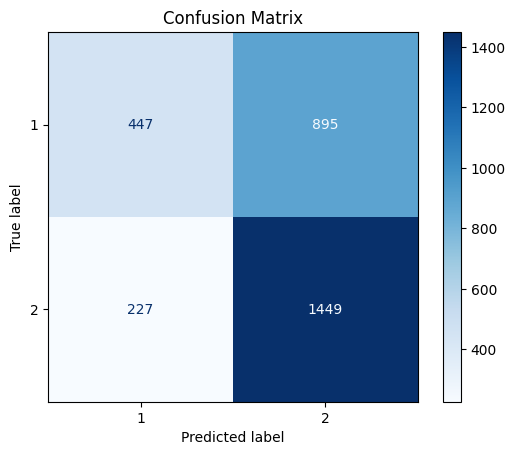


Classification Report:
              precision    recall  f1-score   support

           1     0.6632    0.3331    0.4435      1342
           2     0.6182    0.8646    0.7209      1676

    accuracy                         0.6282      3018
   macro avg     0.6407    0.5988    0.5822      3018
weighted avg     0.6382    0.6282    0.5975      3018



In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

# === CLEAN & PREPARE DATA ===
# Drop rows with NaNs (from shift(-1) and other operations)
data = data.dropna()

# Re-map Target from (-1, 0, 1) → (0, 1, 2) for classification
data['Target'] = np.where(data['Target'] == -1, 0,
                  np.where(data['Target'] == 0, 1, 2))  # now: 0=down, 1=neutral, 2=up

# Define features and target
X = data.drop(columns=['Close', 'High', 'Low', 'Open', 'Target']).values
y = data['Target'].values

# === TRAIN-TEST SPLIT ===
X_train = X[:754]
y_train = y[:754]
X_test = X[754:]
y_test = y[754:]

# === NORMALIZATION ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === BUILD MODEL ===
model = tf.keras.Sequential([
    Dense(512, input_shape=(X_train.shape[1],)),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(256),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dense(3, activation='softmax')  # 3 classes
])

# === COMPILE ===
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === TRAIN ===
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# === EVALUATE ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.6f}")
print(f"Test Accuracy: {accuracy:.6f}")

# === PREDICT ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(np.concatenate((y_test, y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


In [48]:
len(data)


3772

In [77]:
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score  # Import accuracy_score

# Get base predictions and accuracy (multi-class)
y_base = np.argmax(model.predict(X_test), axis=1)
baseline_acc = accuracy_score(y_test, y_base)

# Compute importances
importances = []
for i in range(X_test.shape[1]):
    X_test_permuted = copy.deepcopy(X_test)
    np.random.shuffle(X_test_permuted[:, i])  # Shuffle the i-th feature

    y_perm = np.argmax(model.predict(X_test_permuted), axis=1)
    perm_acc = accuracy_score(y_test, y_perm)

    importances.append(baseline_acc - perm_acc)

# Ensure the feature names are correctly retrieved
feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f"Feature {i}" for i in range(X_test.shape[1])]

# Organize feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Last 10 Trading Strategy Actions:

Price            Close    Return Strategy_Return Action
Ticker             SPY                                 
Date                                                   
2024-12-16  602.940796  0.004270        0.003489   Sell
2024-12-17  600.456665 -0.004120        0.000000    Buy
2024-12-18  582.560974 -0.029803       -0.029803   Hold
2024-12-19  582.382080 -0.000307       -0.000307   Hold
2024-12-20  589.377075  0.012011        0.012011   Hold
2024-12-23  592.906433  0.005988        0.005988   Hold
2024-12-24  599.496582  0.011115        0.011115   Hold
2024-12-26  599.536499  0.000067        0.000067   Hold
2024-12-27  593.225464 -0.010527       -0.010527   Hold
2024-12-30  586.455811 -0.011412       -0.011412   Hold


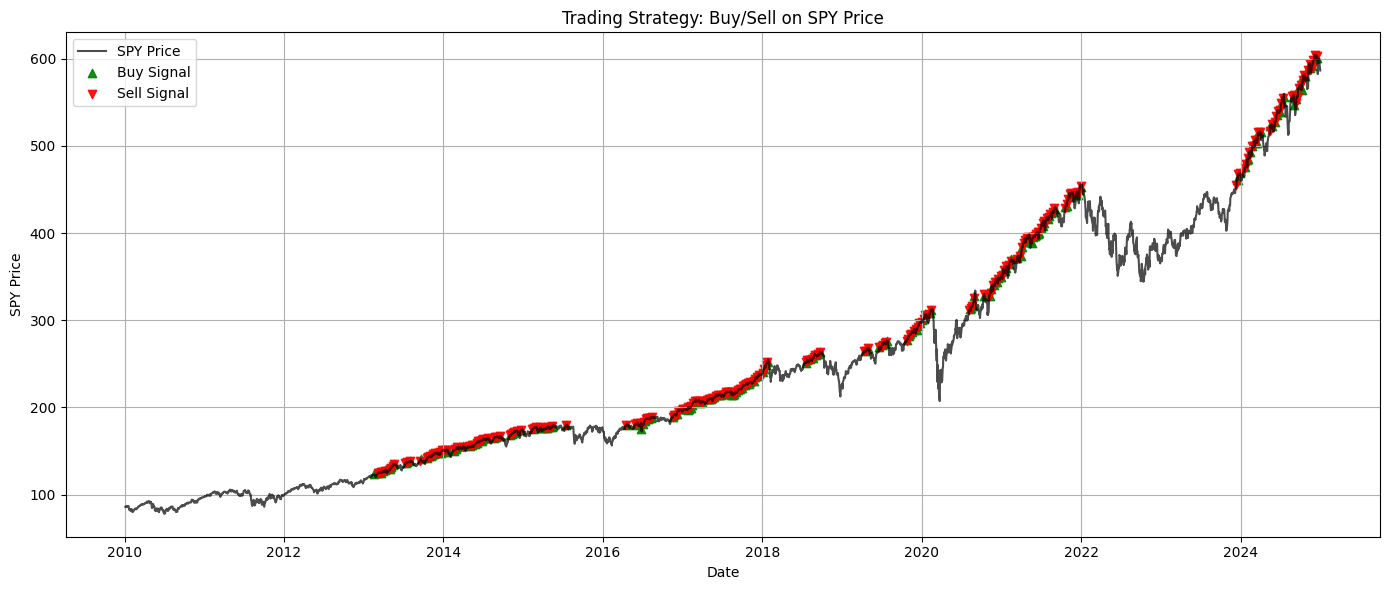

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Predict using trained model (ensure model & X_test already defined)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Map predicted classes to trading signals
pred_signal = pd.Series(y_pred, index=data.iloc[-len(y_pred):].index)
pred_signal = pred_signal.map({0: 0, 1: 0, 2: 1})  # only Buy or Hold (no short)

# 3. Shift signals to simulate real-time trading
data['Signal'] = pred_signal.shift(1).reindex(data.index).fillna(0)

# 4. Initialize trading logic columns
data['Position'] = 0
data['Buy_Price'] = np.nan
data['Holding_Days'] = 0
data['Action'] = ''
strategy_returns = []

# 5. Trading logic loop
holding = False
buy_price = None
holding_days = 0

for i in range(len(data)):
    signal = data['Signal'].iloc[i].item()
    price = data['Close'].iloc[i].item()
    ret = data['Return'].iloc[i].item()

    action = 'Hold'
    strategy_return = 0

    if not holding:
        if signal == 1:
            holding = True
            buy_price = price
            holding_days = 1
            action = 'Buy'
    else:
        gain_pct = (price - buy_price) / buy_price

        if gain_pct >= 0.10:
            holding = False
            action = 'Sell'
            strategy_return = gain_pct
        elif holding_days >= 4 and gain_pct > 0:
            holding = False
            action = 'Sell'
            strategy_return = gain_pct
        elif holding_days < 4 and gain_pct > 0.10:
            holding = False
            action = 'Sell'
            strategy_return = gain_pct
        else:
            strategy_return = ret  # still holding

        if holding:
            holding_days += 1

    # Save to DataFrame
    data.iloc[i, data.columns.get_loc('Position')] = 1 if holding else 0
    data.iloc[i, data.columns.get_loc('Buy_Price')] = buy_price if holding else np.nan
    data.iloc[i, data.columns.get_loc('Holding_Days')] = holding_days if holding else 0
    data.iloc[i, data.columns.get_loc('Action')] = action
    strategy_returns.append(strategy_return if (holding or action == 'Sell') else 0)

# 6. Add strategy return column
data['Strategy_Return'] = strategy_returns

# 7. Show last 10 trades
print("Last 10 Trading Strategy Actions:\n")
print(data[['Close', 'Return', 'Strategy_Return', 'Action']].tail(10))

# 8. Plot signals
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='SPY Price', color='black', alpha=0.7)

buy_signals = data[data['Action'] == 'Buy']
sell_signals = data[data['Action'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=0.9)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=0.9)

plt.title('Trading Strategy: Buy/Sell on SPY Price')
plt.xlabel('Date')
plt.ylabel('SPY Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📈 Performance Summary
Sharpe Ratio: 0.9377
Max Drawdown: -0.3372
Final Strategy Return: 5.8352
Final Market Return: 5.8377


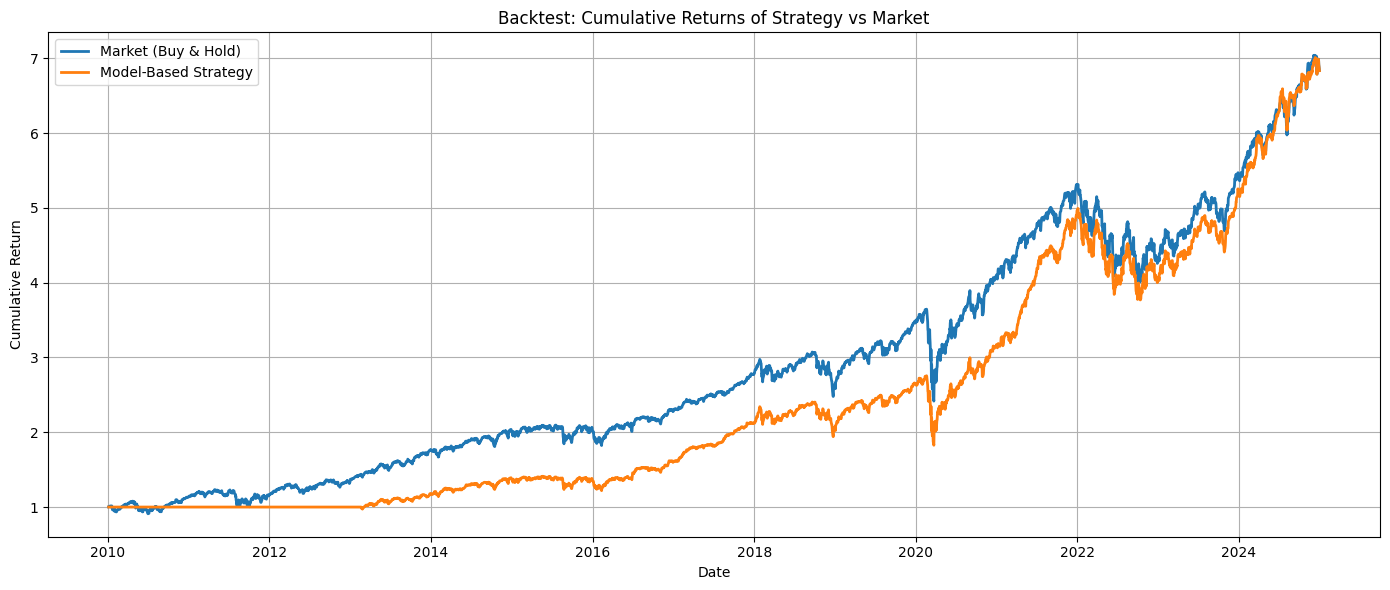

In [52]:
# Make sure Strategy_Return has been computed
if 'Strategy_Return' not in data.columns:
    raise RuntimeError("Please run the trading strategy code first to generate 'Strategy_Return' column.")

# Sharpe Ratio Calculation (Annualized)
strategy_returns = data['Strategy_Return'].dropna()
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)

# Cumulative Return Calculation
data['Cumulative_Market'] = (1 + data['Return']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()

# Max Drawdown Calculation
rolling_max = data['Cumulative_Strategy'].cummax()
drawdown = (data['Cumulative_Strategy'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Performance Summary
summary = {
    "Sharpe Ratio": round(sharpe_ratio, 4),
    "Max Drawdown": round(max_drawdown, 4),
    "Final Strategy Return": round(data['Cumulative_Strategy'].iloc[-1] - 1, 4),
    "Final Market Return": round(data['Cumulative_Market'].iloc[-1] - 1, 4)
}

print("📈 Performance Summary")
for metric, value in summary.items():
    print(f"{metric}: {value}")

# Plotting Cumulative Returns
plt.figure(figsize=(14, 6))
plt.plot(data['Cumulative_Market'], label='Market (Buy & Hold)', linewidth=2)
plt.plot(data['Cumulative_Strategy'], label='Model-Based Strategy', linewidth=2)
plt.title('Backtest: Cumulative Returns of Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


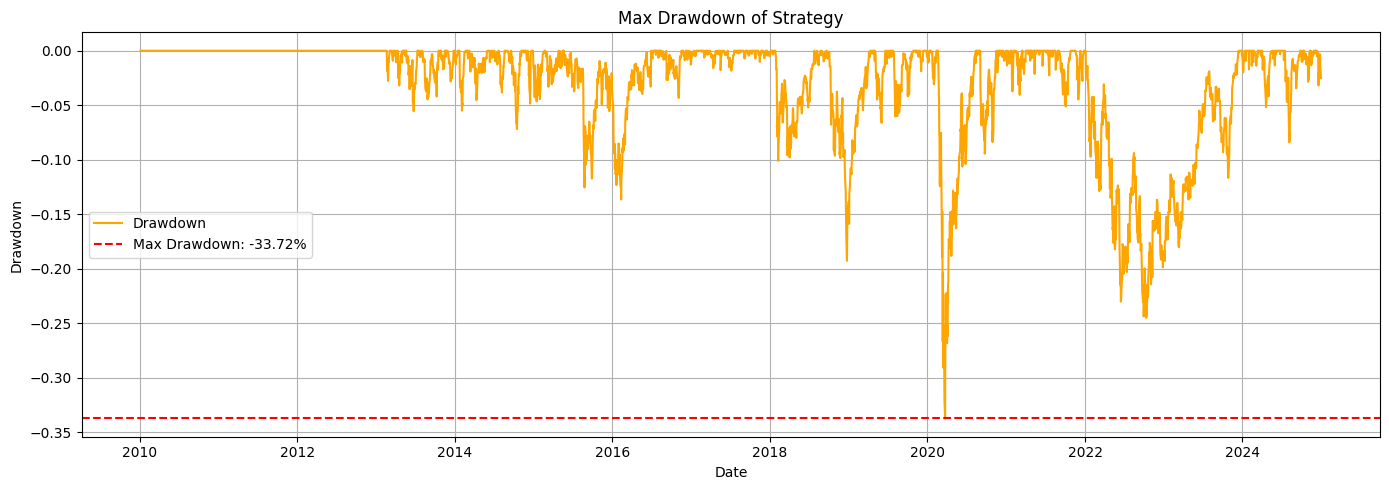

📉 Maximum Drawdown: -33.72% on 2020-03-23


In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Example: Ensure Strategy_Return is available
if 'Strategy_Return' not in data.columns:
    raise RuntimeError("Run the trading strategy code first to compute 'Strategy_Return'.")

# Compute cumulative returns if not already available
if 'Cumulative_Strategy' not in data.columns:
    data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()

# Compute rolling maximum
rolling_max = data['Cumulative_Strategy'].cummax()

# Compute drawdown
drawdown = (data['Cumulative_Strategy'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()
max_drawdown_date = drawdown.idxmin()

# Plot drawdown
plt.figure(figsize=(14, 5))
plt.plot(drawdown, color='orange', label='Drawdown')
plt.axhline(max_drawdown, color='red', linestyle='--', label=f'Max Drawdown: {max_drawdown:.2%}')
plt.title('Max Drawdown of Strategy')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print max drawdown
print(f"📉 Maximum Drawdown: {max_drawdown:.2%} on {max_drawdown_date.date()}")
